# Content
1. [Import dataSet](#1-Import-dataSet)
2. [Glance at data](#2.-Glance-at-data)
    - [2.1 Plot all Features](#2.1-Plot-all-Features)
        - Scatter Plot 
        - Scatter Plot Matrix
        - Plot Line Graphic
    - [2.2 Plot two Features](#2.2-Plot-two-Features)
3. [Machine Learning](#3.-Machine-Learning)
    - [3.1 Splitting Train/Test Dataset](#3.1-Splitting-Train/Test-Dataset)
        - splitting feature(X),label(y) Data
        - splitting train/test data
    - [3.2 Standarizing the feature(X)](#3.2-Standarizing-the-feature(X))
        - StandardScaler
    - [3.3 Train a SVM Model](#3.3-Train-a-SVM-Model)
        - Fitting a model: SVC, y_pred
        - Checking overfitting: svmClf.score, accuracy_score
    - [3.4 Dimensionality Reduction](#3.4-Dimensionality-Reduction)
        - Feature Selection: SBS
    - [3.5 Evaluation](#3.5-Evaluation)
        - for whole features: accuracy_score, classification_report, confusion_matrix
        - for selected features from SBS: accuracy_score, confusion_matrix

## 1 Import dataSet

In [1]:
# !pip install ipynb
from ipynb.fs.full.o_svm_dataset import *

In [2]:
# ds

## 2. Glance at data

### 2.1 Plot all Features

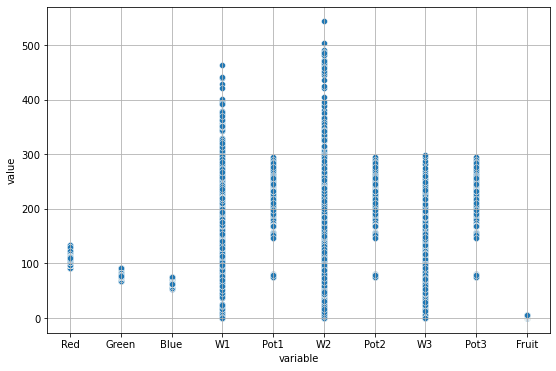

In [3]:
# Scatter Plot
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(9,6))
aaa = pd.melt(ds)
sns.scatterplot(data=aaa, x="variable", y="value")
plt.grid()
plt.savefig('9feature.eps', dpi=300)

In [4]:
# Scatter Plot Matrix
import seaborn as sns
# sns.pairplot(ds)

In [5]:
# Plot Line Graphic
# print(len(ds))
plt.figure(figsize=(20,10))
x = np.linspace(0, len(ds), len(ds))
y = ds.loc[:,'Red':'Pot3']
# plt.plot(x,y,'-o')
# plt.show()

<Figure size 1440x720 with 0 Axes>

### 2.2 Plot two Features

/home/ash/anaconda3/envs/tensorflow1_14/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaq

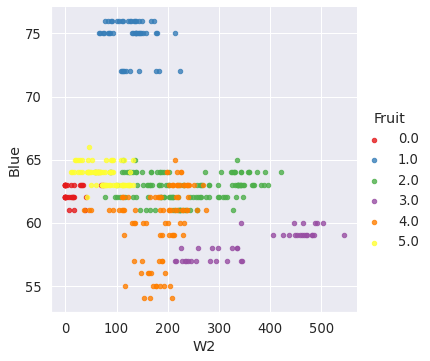

In [6]:
import seaborn as sns; sns.set(font_scale=1.2)
sns.lmplot('W2', 'Blue', data=ds, hue='Fruit',
           palette='Set1', fit_reg=False, scatter_kws={"s": 20})

plt.savefig('2feature.eps', dpi=300)

## 3. Machine Learning

### 3.1 Splitting Train/Test Dataset
- splitting feature(X),label(y) Data

In [7]:
X = ds.drop('Fruit', axis=1)
y = ds['Fruit']
y = y.to_numpy(dtype='int')
print('Class labels:', np.unique(y))

Class labels: [0 1 2 3 4 5]


- splitting train/test data

In [8]:
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

### 3.2 Standarizing the feature(X)

In [9]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

### 3.3 Train a SVM Model

- fitting a model

In [10]:
from sklearn import svm

# svmClf = svm.SVC(C=1, kernel='linear', gamma='auto', random_state=1)
svmClf = svm.SVC(C=10, kernel='rbf', gamma='scale', random_state=1)  #best parameters

svmClf.fit(X_train_std, y_train)

SVC(C=10, random_state=1)

In [11]:
# svm.SVC?

- checking SVM model if it is overfitting

In [12]:
from sklearn.metrics import accuracy_score

y_train_pred = svmClf.predict(X_train_std)
svm_train = accuracy_score(y_train, y_train_pred)

y_test_pred = svmClf.predict(X_test_std)
svm_test = accuracy_score(y_test, y_test_pred)

print('SVM Train Accuracy %.3f' % (svm_train))
print('SVM Test Accuracy %.3f' % (svm_test))

SVM Train Accuracy 0.991
SVM Test Accuracy 0.966


In [13]:
misclass = (y_test != y_test_pred).sum()
print('Misclassified examples: %d' % misclass)

Misclassified examples: 3


In [14]:
score_train = svmClf.score(X_train_std, y_train)
score_test = svmClf.score(X_test_std, y_test)
print('Accuracy: %.3f' % score_train)
print('Accuracy: %.3f' % score_test)

Accuracy: 0.991
Accuracy: 0.966


### 3.4 Dimensionality Reduction

In [15]:
from sklearn.base import clone
from itertools import combinations
import numpy as np

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

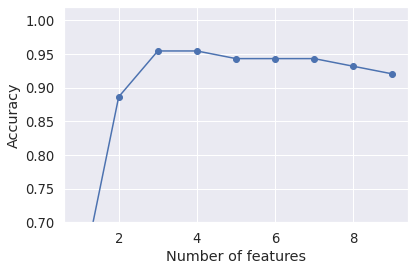

In [16]:
# svmClf = svm.SVC(C=1, kernel='linear', gamma='auto', random_state=1)

sbs = SBS(svmClf, k_features=1)
sbs.fit(X_train_std, y_train)
# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.tight_layout()
# plt.savefig('images/04_08.png', dpi=300)
# plt.show()

In [17]:
for i in range(9):
    i = list(sbs.subsets_[i])
    print (ds.columns[0:][i])

Index(['Red', 'Green', 'Blue', 'W1', 'Pot1', 'W2', 'Pot2', 'W3', 'Pot3'], dtype='object')
Index(['Red', 'Green', 'Blue', 'W1', 'Pot1', 'W2', 'Pot2', 'Pot3'], dtype='object')
Index(['Red', 'Blue', 'W1', 'Pot1', 'W2', 'Pot2', 'Pot3'], dtype='object')
Index(['Red', 'Blue', 'W1', 'Pot1', 'W2', 'Pot2'], dtype='object')
Index(['Red', 'Blue', 'W1', 'Pot1', 'W2'], dtype='object')
Index(['Red', 'Blue', 'W1', 'W2'], dtype='object')
Index(['Blue', 'W1', 'W2'], dtype='object')
Index(['Blue', 'W2'], dtype='object')
Index(['W2'], dtype='object')


In [18]:
k4 = list(sbs.subsets_[5])

In [19]:
print(ds.columns[0:][k4])

Index(['Red', 'Blue', 'W1', 'W2'], dtype='object')


### 3.5 Evaluation

- for all features

In [20]:
# svmClf.fit(X_train_std, y_train)
print('Training accuracy:', svmClf.score(X_train_std, y_train))
print('Test accuracy:', svmClf.score(X_test_std, y_test))

Training accuracy: 0.9914040114613181
Test accuracy: 0.9659090909090909


In [21]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_test_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00        10
           2       0.93      0.96      0.95        27
           3       1.00      1.00      1.00         8
           4       1.00      0.89      0.94        19
           5       0.94      1.00      0.97        17

    accuracy                           0.97        88
   macro avg       0.98      0.98      0.98        88
weighted avg       0.97      0.97      0.97        88



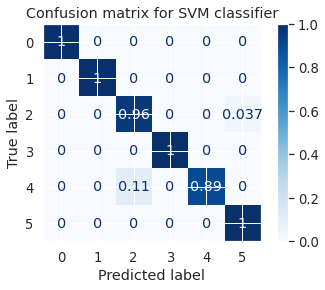

In [22]:
# ref: https://www.youtube.com/watch?v=zUqa6KcwRhs&list=WL&index=8&t=671s
from sklearn.metrics import plot_confusion_matrix

matrix = plot_confusion_matrix(svmClf, X_test_std, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for SVM classifier')
plt.savefig('confusionMatrix.eps', dpi=300)
# plt.show(matrix)
# plt.show()

- for selected features from SBS

In [23]:
svmClf.fit(X_train_std[:, k4], y_train)
print('Training accuracy:', svmClf.score(X_train_std[:, k4], y_train))
print('Test accuracy:', svmClf.score(X_test_std[:, k4], y_test))

Training accuracy: 0.9426934097421203
Test accuracy: 0.9545454545454546


Text(0.5, 1.0, 'Confusion matrix for SVM classifier')

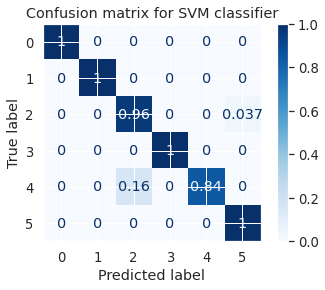

In [24]:
from sklearn.metrics import plot_confusion_matrix

matrix = plot_confusion_matrix(svmClf, X_test_std[:, k4], y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for SVM classifier')


In [25]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
